In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas.tseries.offsets import MonthEnd

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data and Merge

In [3]:
# 改成自己电脑上的文件夹路径(注意尽量使用"/"而不是"\")
path = './股票年报数据'

## Import the Book Equity Data

In [339]:
#pip install xlrd==1.2.0

In [4]:
factors=pd.read_excel(f'{path}/factors_monthly_2023.xlsx')

In [10]:
factors["trdmnt"]=pd.to_datetime(factors["trdmnt"], format='%Y-%m')+ MonthEnd(1)
factors.rename(columns={'trdmnt':'date'}, inplace=True)
factors.index=factors['date']
factors.drop(columns=['date'], inplace=True)

In [340]:
Carhart=pd.read_csv(f'{path}/Carhart-四因子模型.csv')

In [341]:
Carhart['date'] = pd.to_datetime(Carhart['date'], format='%Y-%m-%d')
Carhart.index=Carhart['date']
Carhart.head()

,date,RF,MKT,SMB,HML,UMD
date,,,,,,
1995-01-31,1995-01-31,0.003464,-0.131853,-0.017529,0.011962,0.000000
1995-02-28,1995-02-28,0.003099,-0.021627,-0.009473,0.030855,-0.023258
1995-03-31,1995-03-31,0.004194,0.158785,0.014816,-0.081852,0.128701
1995-04-30,1995-04-30,0.003646,-0.110414,0.011098,-0.014453,0.011704
1995-05-31,1995-05-31,0.004012,0.181230,0.040269,-0.097016,0.053108


In [342]:
Daniel=pd.read_csv(f'{path}/Daniel-Hirshleifer-Sun-三因子模型.csv')

In [343]:
Daniel['date'] = pd.to_datetime(Daniel['date'], format='%Y-%m-%d')
Daniel.index=Daniel['date']
Daniel.head()

,date,RF,MKT,R_fin,R_pead
date,,,,,
2002-04-30,2002-04-30,NaN,NaN,NaN,NaN
2002-05-31,2002-05-31,0.000846,-0.085376,0.006979,-0.002118
2002-06-30,2002-06-30,0.000940,0.132574,-0.005108,-0.007183
2002-07-31,2002-07-31,0.001082,-0.038903,0.007754,0.013432
2002-08-31,2002-08-31,0.001206,0.007829,-0.000327,-0.001809


In [344]:
balance_sheet = pd.read_excel(f'{path}/FS_Combas.xlsx',dtype={'S_INFO_WINDCODE':str})

d:\Anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Stkcd [证券代码] - 以上海交易所、深圳证券交易所公布的证券代码为准

Accper [会计期间] - YYYY-MM-DD，前四位表示会计报表公布年度

Typrep [报表类型] - 指上市公司的财务报表中反映的是合并报表或者母公司报表。“A＝合并报表”、“B＝母公司报表”。

A001000000 [资产总计] - 资产各项目之总计。1990年起使用

A003000000 [所有者权益合计] - 股东权益各项目之合计。1990年起使用

In [345]:
balance_sheet=balance_sheet.iloc[2:, :]
balance_sheet.head()

,Stkcd,ShortName,Accper,Typrep,A001000000,A003000000
2,000001,S 深发展A,2006-12-31,A,260576263238,6474463247
3,000001,深发展A,2007-01-01,A,260760692000,6597040000
4,000001,S 深发展A,2007-03-31,A,287658610892,7106094008
5,000001,深发展A,2007-06-30,A,314056006000,7698478000
6,000001,深发展A,2007-09-30,A,340526939000,8363553000


In [346]:
#rename variables' names
balance_sheet = balance_sheet.rename(columns = {'A001000000': 'total_at', 'A003000000': 'total_eqt'})
#generate the year variable of book equity
balance_sheet['Accper'] = pd.to_datetime(balance_sheet['Accper'])
balance_sheet['year'] = balance_sheet['Accper'].dt.year

balance_sheet['month'] = balance_sheet['Accper'].dt.month
balance_sheet = balance_sheet[balance_sheet['month']==12] # 仅保留年报

balance_sheet = balance_sheet[['Stkcd','year', 'total_at', 'total_eqt']].copy()
balance_sheet

,Stkcd,year,total_at,total_eqt
2,000001,2006,260576263238,6474463247
7,000001,2007,352539361000,13006063000
12,000001,2008,474440173000,16400790000
17,000001,2009,587811034000,20469609000
22,000001,2010,727207076000,33197535000
...,...,...,...,...
591016,920992,2022,789318038.9,612310111.2
591025,920992,2023,732823882.42,601519972.36
591026,920992,2023,727433269.14,613439941.52
591035,920992,2024,745276424.53,611741106.18


## Import Market Value and Monthly Return Data

In [347]:
mv_ret = pd.read_excel(f'{path}/TRD_Mnth.xlsx')
mv_ret

d:\Anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Trdmnt,Msmvosd,Msmvttl,Mretwd
0,证券代码,交易月份,月个股流通市值,月个股总市值,考虑现金红利再投资的月个股回报率
1,没有单位,没有单位,千元,千元,没有单位
2,000001,2000-12,20228171.57,28253337.6,-0.062621
3,000001,2001-01,20869008.96,29148415.79,0.03168
4,000001,2001-02,19629127.92,27416634.08,-0.059413
...,...,...,...,...,...
833362,920992,2025-06,593115.24,2056499.66,0.039101
833363,920992,2025-07,626035.09,2170642.16,0.055503
833364,920992,2025-08,603995.53,2094224.72,-0.035205
833365,920992,2025-09,587814.59,2038120.78,-0.02679


Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准

Trdmnt [交易月份] - 以YYYY-MM表示

Msmvttl [月个股总市值] - 个股的发行总股数与月收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千

Mretwd [考虑现金红利再投资的月个股回报率] - 字段说明见“回报率计算方法”

In [348]:
mv_ret=mv_ret.iloc[2:, :]
mv_ret.head()

,Stkcd,Trdmnt,Msmvosd,Msmvttl,Mretwd
2,000001,2000-12,20228171.57,28253337.6,-0.062621
3,000001,2001-01,20869008.96,29148415.79,0.03168
4,000001,2001-02,19629127.92,27416634.08,-0.059413
5,000001,2001-03,22596483.67,31561235.26,0.151171
6,000001,2001-04,21635227.58,30218617.97,-0.04254


In [349]:
mv_ret = mv_ret.rename(columns={'Msmvttl': 'mv', 'Mretwd' :'ret'})
#generate the date variable of stock return
mv_ret['date'] = pd.to_datetime(mv_ret['Trdmnt'], format= '%Y-%m')+MonthEnd()
mv_ret = mv_ret[['Stkcd','date','mv','ret']].copy()
mv_ret

,Stkcd,date,mv,ret
2,000001,2000-12-31,28253337.6,-0.062621
3,000001,2001-01-31,29148415.79,0.03168
4,000001,2001-02-28,27416634.08,-0.059413
5,000001,2001-03-31,31561235.26,0.151171
6,000001,2001-04-30,30218617.97,-0.04254
...,...,...,...,...
833362,920992,2025-06-30,2056499.66,0.039101
833363,920992,2025-07-31,2170642.16,0.055503
833364,920992,2025-08-31,2094224.72,-0.035205
833365,920992,2025-09-30,2038120.78,-0.02679


In [350]:
#monthly mv data
mv = mv_ret[['Stkcd', 'date','mv']].copy()
#note that the original mv is in thounsand
mv['mv'] = mv['mv']*1000

#December end mv
#the December mv is used to calculate bm ratio (the HML factor)
mv_dec = mv[mv['date'].dt.month==12].reset_index(drop=True).copy()
#April end mv
#the April mv is used for sorting by size (the SMB factor)
mv_apr = mv[mv['date'].dt.month==4].reset_index(drop=True).copy()

#generate the year variable of market value
#the December mv is to calculate bm ratio
#we will merge Year T's book equity and Year T December's mv to calculate bm
mv_dec['year'] = mv_dec['date'].dt.year

#the April mv is used for sorting by size
#we will merge the year T's bm ratio and year T+1 April's mv
mv_apr['year'] = mv_apr['date'].dt.year - 1

In [351]:
mv

,Stkcd,date,mv
2,000001,2000-12-31,28253337600.0
3,000001,2001-01-31,29148415790.0
4,000001,2001-02-28,27416634080.0
5,000001,2001-03-31,31561235260.0
6,000001,2001-04-30,30218617970.0
...,...,...,...
833362,920992,2025-06-30,2056499660.0
833363,920992,2025-07-31,2170642160.0
833364,920992,2025-08-31,2094224720.0
833365,920992,2025-09-30,2038120780.0


In [352]:
mv_dec

,Stkcd,date,mv,year
0,000001,2000-12-31,28253337600.0,2000
1,000001,2001-12-31,23836321330.0,2001
2,000001,2002-12-31,20411674340.0,2002
3,000001,2003-12-31,16558946490.0,2003
4,000001,2004-12-31,12822967960.0,2004
...,...,...,...,...
68232,920985,2023-12-31,2751243420.0,2023
68233,920985,2024-12-31,3094762000,2024
68234,920992,2022-12-31,1127882690.0,2022
68235,920992,2023-12-31,1238155960.0,2023


In [353]:
mv_apr

,Stkcd,date,mv,year
0,000001,2001-04-30,30218617970.0,2000
1,000001,2002-04-30,22376954710.0,2001
2,000001,2003-04-30,24186569310.0,2002
3,000001,2004-04-30,18154520650.0,2003
4,000001,2005-04-30,12064097320.0,2004
...,...,...,...,...
69368,920985,2024-04-30,1810435770.0,2023
69369,920985,2025-04-30,2983350570.0,2024
69370,920992,2023-04-30,938290060.0,2022
69371,920992,2024-04-30,911205400.0,2023


## Calculate BM ratio

In [354]:
#BM ratio is calculated as
#Year T's book equity ÷ Year T December's market equity
bm = pd.merge(balance_sheet, mv_dec,
              on = ['Stkcd' ,'year'],
              how = 'inner')
bm['bm'] = bm['total_eqt'] / bm['mv']
bm = bm[['Stkcd', 'year', 'bm']]
bm

,Stkcd,year,bm
0,000001,2006,0.229949
1,000001,2007,0.146919
2,000001,2008,0.558279
3,000001,2009,0.270478
4,000001,2010,0.60328
...,...,...,...
119394,920992,2022,0.542885
119395,920992,2023,0.485819
119396,920992,2023,0.495446
119397,920992,2024,0.461954


## Merge MV and BM

In [355]:
#when we calculate the size factor
#we should use Year T+1 April's market value
mv_apr = mv_apr[['Stkcd','year','mv']].copy()
bm_mv = pd.merge(bm, mv_apr,
                 on = ['Stkcd','year'],
                 how = 'inner')
#drop observations containing NAs
bm_mv = bm_mv.dropna(axis=0, how='any').copy()
#drop firms with negative book equity
bm_mv = bm_mv[bm_mv['bm']>0].copy()
bm_mv

,Stkcd,year,bm,mv
0,000001,2006,0.229949,50494084770.0
1,000001,2007,0.146919,67930719629.999992
2,000001,2008,0.558279,50680679000
3,000001,2009,0.270478,63847718150.0
4,000001,2010,0.60328,63427250470.0
...,...,...,...,...
117640,920992,2022,0.542885,938290060.0
117641,920992,2023,0.485819,911205400.0
117642,920992,2023,0.495446,911205400.0
117643,920992,2024,0.461954,1889155140.0


# Double Sort

In [489]:
bm_mv

,Stkcd,year,bm,mv,size_group,bm_group
0,000001,2006,0.229949,50494084770.0,B,L
1,000001,2007,0.146919,67930719629.999992,B,M
2,000001,2008,0.558279,50680679000,B,M
3,000001,2009,0.270478,63847718150.0,B,M
4,000001,2010,0.60328,63427250470.0,B,H
...,...,...,...,...,...,...
117640,920992,2022,0.542885,938290060.0,S,M
117641,920992,2023,0.485819,911205400.0,S,M
117642,920992,2023,0.495446,911205400.0,S,M
117643,920992,2024,0.461954,1889155140.0,S,M


In [494]:
cols = ['mv', 'bm']      
bm_mv[cols] = bm_mv[cols].apply(pd.to_numeric, errors='coerce')

In [495]:
import re

def is_mainboard(code: str) -> bool:
    """
    code: 6 位数字字符串，如 '000001'
    返回 True 表示主板
    """
    return bool(re.fullmatch(r'(60\d{4}|000\d{3}|001\d{3})', code))


In [496]:
# 先把股票代码统一成 6 位字符串
bm_mv['Stkcd'] = bm_mv['Stkcd'].astype(str).str.zfill(6)
main_board = bm_mv[bm_mv['Stkcd'].apply(is_mainboard)].copy()

In [497]:
mv_q = (main_board.groupby("year")['mv']
                   .quantile([0.5])
                   .unstack()
                   .rename(columns={0.5: 'mv_q50'}))
bm_mv=bm_mv.merge(mv_q, on='year', how='left')

condas = [
    bm_mv['mv'] <= bm_mv['mv_q50'],          # 前 50 %
    bm_mv['mv'] > bm_mv['mv_q50']            # 后   50 %
]   
choicesas = ['S', 'B']   # S=small size，B=big size

bm_mv['size_group'] = np.select(condas, choicesas, default=np.nan)

In [500]:
bm_q = (main_board.groupby("year")['bm']
                   .quantile([0.3, 0.7])
                   .unstack()
                   .rename(columns={0.3: 'bm_q30', 0.7: 'bm_q70'}))
bm_mv=bm_mv.merge(bm_q, on='year', how='left')

condas = [
    bm_mv['bm'] <= bm_mv['bm_q30'],          # 30      
    bm_mv['bm'] > bm_mv['bm_q70']            # 70
]   
choices = ['L', 'H']   # L=low BM，H=high BM
bm_mv['bm_group'] = np.select(condas, choices, default='M')


In [501]:
bm_mv

,Stkcd,year,bm,mv,size_group,bm_group,mv_q50,CEI_q30,CEI_q70,CEI_group,bm_q30,bm_q70
0,000001,2006,0.229949,5.049408e+10,B,L,3.831131e+09,0.342384,0.626795,L,0.342384,0.626795
1,000001,2007,0.146919,6.793072e+10,B,M,3.939139e+09,0.137447,0.252315,M,0.137447,0.252315
2,000001,2008,0.558279,5.068068e+10,B,M,3.237377e+09,0.377380,0.687680,M,0.377380,0.687680
3,000001,2009,0.270478,6.384772e+10,B,M,4.886318e+09,0.176341,0.322302,M,0.176341,0.322302
4,000001,2010,0.603280,6.342725e+10,B,H,5.594456e+09,0.182242,0.361691,H,0.182242,0.361691
...,...,...,...,...,...,...,...,...,...,...,...,...
116674,920992,2022,0.542885,9.382901e+08,S,M,7.266915e+09,0.338368,0.722679,M,0.338368,0.722679
116675,920992,2023,0.485819,9.112054e+08,S,M,6.312988e+09,0.345686,0.719308,M,0.345686,0.719308
116676,920992,2023,0.495446,9.112054e+08,S,M,6.312988e+09,0.345686,0.719308,M,0.345686,0.719308
116677,920992,2024,0.461954,1.889155e+09,S,M,6.866027e+09,0.370623,0.740285,M,0.370623,0.740285


In [502]:
#bm_mv['size_group'] = bm_mv.groupby(['year'])['mv'].transform(pd.qcut, [0,0.5,1] ,labels= ['S','B'])
#bm_mv['bm_group'] =bm_mv.groupby(['year'])['bm'].transform(pd.qcut, [0,0.3,0.7,1], labels=['L','M','H'])
stk_sort = bm_mv[['Stkcd','year','size_group','bm_group','mv']].copy()
#note that the year is for merge with monthly return data
#rename it to m_year (m stands for merge)
stk_sort = stk_sort.rename(columns={'year':'m_year'})
stk_sort

,Stkcd,m_year,size_group,bm_group,mv
0,000001,2006,B,L,5.049408e+10
1,000001,2007,B,M,6.793072e+10
2,000001,2008,B,M,5.068068e+10
3,000001,2009,B,M,6.384772e+10
4,000001,2010,B,H,6.342725e+10
...,...,...,...,...,...
116674,920992,2022,S,M,9.382901e+08
116675,920992,2023,S,M,9.112054e+08
116676,920992,2023,S,M,9.112054e+08
116677,920992,2024,S,M,1.889155e+09


# Calculate the Factors

## Merge Stock Sort and Monthly Return

In [503]:
#for Year T Jan~April stock return, use the Year T-2 sort
#for Year T May~Dec stock return, use the Year T-1 sort
#should be careful here to avoid looking-ahead bias
mv_ret['m_year'] = mv_ret['date'].dt.year -1
mv_ret.loc[mv_ret['date'].dt.month<=4,'m_year'] = mv_ret['date'].dt.year-2
mv_ret

,Stkcd,date,mv,ret,m_year
2,000001,2000-12-31,28253337.6,-0.062621,1999
3,000001,2001-01-31,29148415.79,0.03168,1999
4,000001,2001-02-28,27416634.08,-0.059413,1999
5,000001,2001-03-31,31561235.26,0.151171,1999
6,000001,2001-04-30,30218617.97,-0.04254,1999
...,...,...,...,...,...
833362,920992,2025-06-30,2056499.66,0.039101,2024
833363,920992,2025-07-31,2170642.16,0.055503,2024
833364,920992,2025-08-31,2094224.72,-0.035205,2024
833365,920992,2025-09-30,2038120.78,-0.02679,2024


In [504]:
#merge stock sort and stock return
ret_sort = pd.merge(mv_ret, stk_sort,
                    on = ['Stkcd','m_year'],
                    how = 'inner')
ret_sort

,Stkcd,date,mv_x,ret,m_year,size_group,bm_group,mv_y
0,000001,2007-05-31,55825637.45,0.105588,2006,B,L,5.049408e+10
1,000001,2007-06-30,57427589.65,0.055417,2006,B,L,5.049408e+10
2,000001,2007-07-31,75603254.84,0.316497,2006,B,L,5.049408e+10
3,000001,2007-08-31,79296817.11,0.048855,2006,B,L,5.049408e+10
4,000001,2007-09-30,83428598.63,0.052105,2006,B,L,5.049408e+10
...,...,...,...,...,...,...,...,...
1314519,920992,2025-08-31,2094224.72,-0.035205,2024,S,M,1.889155e+09
1314520,920992,2025-09-30,2038120.78,-0.02679,2024,S,M,1.889155e+09
1314521,920992,2025-09-30,2038120.78,-0.02679,2024,S,M,1.889155e+09
1314522,920992,2025-10-31,2157099.83,0.058377,2024,S,M,1.889155e+09


In [505]:
#define the value weighted return calculation function
def calc_vw_ret(data, weight_var, ret_var):
    d = data[ret_var]
    w = data[weight_var]
    try:
        return (d*w).sum()/w.sum()
    except ZeroDivisionError:
        return np.nan

In [506]:
MKT= ret_sort.groupby(['date']).apply(calc_vw_ret, 'mv_y','ret').reset_index().rename(columns={0:'MKT'})
MKT.index=MKT['date']
MKT=MKT['MKT']

C:\Users\李想\AppData\Local\Temp\ipykernel_26696\564263406.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  MKT= ret_sort.groupby(['date']).apply(calc_vw_ret, 'mv_y','ret').reset_index().rename(columns={0:'MKT'})


In [507]:
MKT

date
2007-05-31    0.099069
2007-06-30   -0.092843
2007-07-31    0.187370
2007-08-31    0.150553
2007-09-30    0.056442
                ...   
2025-06-30    0.042207
2025-07-31    0.045071
2025-08-31    0.091553
2025-09-30    0.012988
2025-10-31    0.013037
Name: MKT, Length: 222, dtype: float64

In [508]:
#calculate the value-weight return for each portfolio
vw_ret = ret_sort.groupby(['date', 'size_group','bm_group']).apply(calc_vw_ret, 'mv_y','ret').reset_index().rename(columns={0:'portfolio_ret'})
vw_ret

C:\Users\李想\AppData\Local\Temp\ipykernel_26696\3488688684.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_ret = ret_sort.groupby(['date', 'size_group','bm_group']).apply(calc_vw_ret, 'mv_y','ret').reset_index().rename(columns={0:'portfolio_ret'})


,date,size_group,bm_group,portfolio_ret
0,2007-05-31,B,H,0.072400
1,2007-05-31,B,L,0.091379
2,2007-05-31,B,M,0.123498
3,2007-05-31,S,H,0.094831
4,2007-05-31,S,L,0.083310
...,...,...,...,...
1327,2025-10-31,B,L,-0.022132
1328,2025-10-31,B,M,0.016680
1329,2025-10-31,S,H,0.042963
1330,2025-10-31,S,L,0.015069


In [509]:
vw_ret_pivot = vw_ret.pivot_table(index = 'date',columns=['size_group', 'bm_group'], values='portfolio_ret')
vw_ret_pivot

size_group         B                             S                    
bm_group           H         L         M         H         L         M
date                                                                  
2007-05-31  0.072400  0.091379  0.123498  0.094831  0.083310  0.079264
2007-06-30 -0.158337 -0.036051 -0.092015 -0.226552 -0.162052 -0.185948
2007-07-31  0.235207  0.166025  0.167959  0.258188  0.241383  0.253138
2007-08-31  0.157352  0.163041  0.148552  0.105609  0.089910  0.121292
2007-09-30  0.120864  0.021591  0.072960  0.043470  0.028489  0.047647
...              ...       ...       ...       ...       ...       ...
2025-06-30  0.040798  0.038784  0.032644  0.049087  0.077600  0.069272
2025-07-31  0.036785  0.051018  0.042907  0.060002  0.041557  0.054159
2025-08-31  0.029314  0.152170  0.083890  0.045549  0.088037  0.074682
2025-09-30 -0.030196  0.050097  0.017878  0.016737 -0.015572  0.003161
2025-10-31  0.049572 -0.022132  0.016680  0.042963  0.015069  0.022819

[222 rows x 6 columns]

In [510]:
#calculate the SMB and HML
SMB = vw_ret_pivot.xs('S',level=0,axis=1).mean(axis=1)-vw_ret_pivot.xs('B',level=0,axis=1).mean(axis=1)
HML = vw_ret_pivot.xs('H',level=1,axis=1).mean(axis=1)-vw_ret_pivot.xs('L',level=1,axis=1).mean(axis=1)

In [511]:
SMB

date
2007-05-31   -0.009957
2007-06-30   -0.096050
2007-07-31    0.061173
2007-08-31   -0.050711
2007-09-30   -0.031936
                ...   
2025-06-30    0.027911
2025-07-31    0.008336
2025-08-31   -0.019036
2025-09-30   -0.011151
2025-10-31    0.012244
Length: 222, dtype: float64

In [512]:
HML

date
2007-05-31   -0.003729
2007-06-30   -0.093393
2007-07-31    0.042993
2007-08-31    0.005005
2007-09-30    0.057127
                ...   
2025-06-30   -0.013249
2025-07-31    0.002105
2025-08-31   -0.082672
2025-09-30   -0.023992
2025-10-31    0.049800
Length: 222, dtype: float64

In [367]:
import matplotlib.pyplot as plt

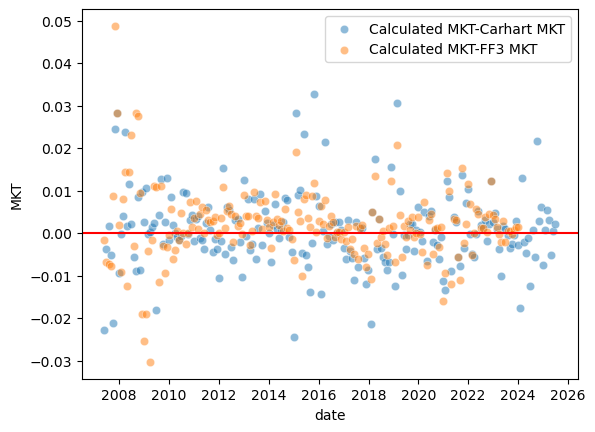

In [543]:
plt.figure()
sns.scatterplot(MKT-Carhart["MKT"][Carhart["date"]>='2007-5-31'],alpha=0.5)
sns.scatterplot(MKT-factors["mkt"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated MKT-Carhart MKT','Calculated MKT-FF3 MKT'])
plt.axhline(y=0, color='r')

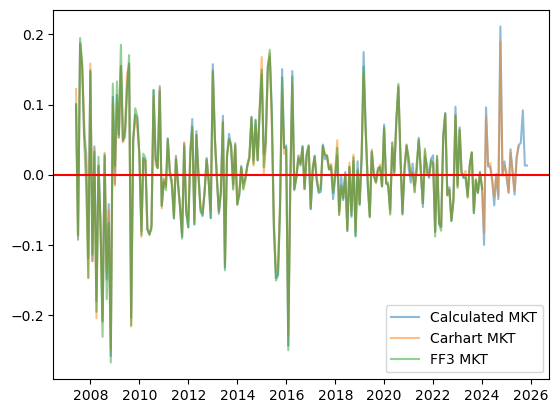

In [547]:
plt.plot(MKT,alpha=0.5)
plt.plot(Carhart["MKT"][Carhart["date"]>='2007-5-31'],alpha=0.5)
plt.plot(factors["mkt"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated MKT','Carhart MKT',"FF3 MKT"])
plt.axhline(y=0, color='r')

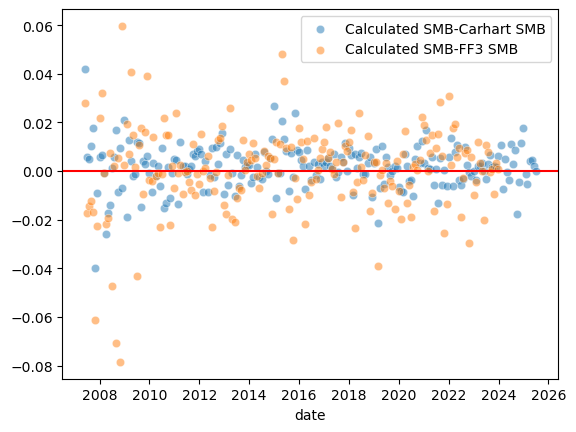

In [542]:
plt.figure()
sns.scatterplot(SMB-Carhart["SMB"][Carhart["date"]>='2007-5-31'],alpha=0.5)
sns.scatterplot(SMB-factors["smbff3"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated SMB-Carhart SMB','Calculated SMB-FF3 SMB'])
plt.axhline(y=0, color='r')

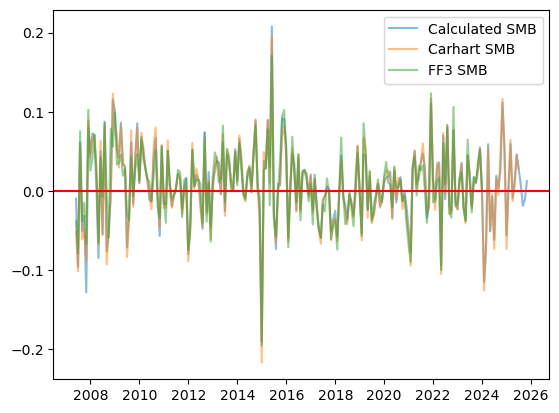

In [538]:
plt.plot(SMB,alpha=0.5)
plt.plot(Carhart["SMB"][Carhart["date"]>='2007-5-31'],alpha=0.5)
plt.plot(factors["smbff3"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated SMB','Carhart SMB', 'FF3 SMB'])
plt.axhline(y=0, color='r')

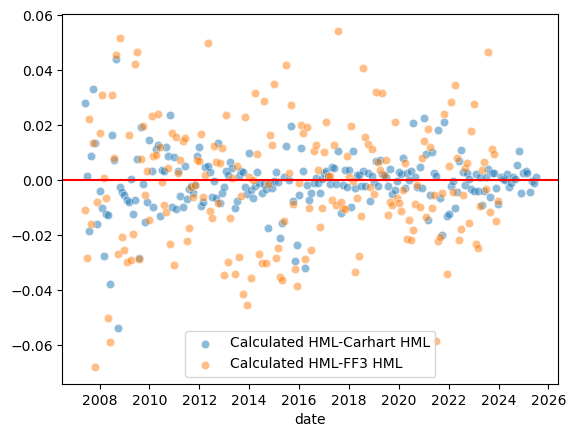

In [544]:
plt.figure()
sns.scatterplot(HML-Carhart["HML"][Carhart["date"]>='2007-5-31'],alpha=0.5)
sns.scatterplot(HML-factors["hmlff3"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated HML-Carhart HML','Calculated HML-FF3 HML'])
plt.axhline(y=0, color='r')

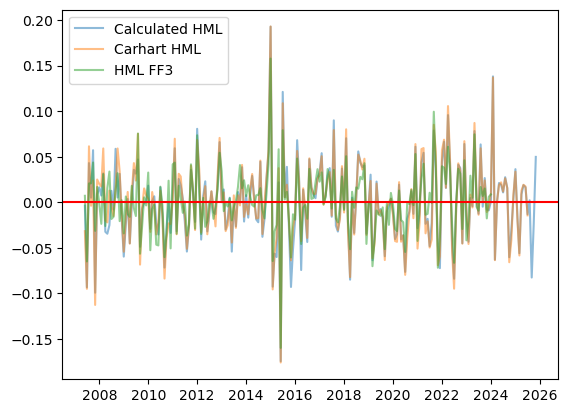

In [546]:
plt.plot(HML,alpha=0.5)
plt.plot(Carhart["HML"][Carhart["date"]>='2007-5-31'],alpha=0.5)
plt.plot(factors["hmlff3"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated HML','Carhart HML','HML FF3'])
plt.axhline(y=0, color='r')

FIN计算过程如下
ST股票已在数据下载中剔除

In [ ]:
equity_sum=mv_ret.copy()

In [411]:
equity_sum

,Stkcd,date,mv,ret,m_year
2,000001,2000-12-31,28253337.6,-0.062621,1999
3,000001,2001-01-31,29148415.79,0.03168,1999
4,000001,2001-02-28,27416634.08,-0.059413,1999
5,000001,2001-03-31,31561235.26,0.151171,1999
6,000001,2001-04-30,30218617.97,-0.04254,1999
...,...,...,...,...,...
833362,920992,2025-06-30,2056499.66,0.039101,2024
833363,920992,2025-07-31,2170642.16,0.055503,2024
833364,920992,2025-08-31,2094224.72,-0.035205,2024
833365,920992,2025-09-30,2038120.78,-0.02679,2024


In [413]:
# 1. 确保日期格式 + 排序
equity_sum = equity_sum.sort_values(['Stkcd', 'date'])

# 2. 计算 (1 + 月收益)
equity_sum['one_plus'] = 1 + equity_sum['ret']

# 3. 每个股票做 60 期滚动乘积
equity_sum['cum_prod'] = (equity_sum.groupby('Stkcd')['one_plus']
                    .transform(lambda x: x.rolling(window=60, min_periods=60).apply(lambda y: y.prod())))

# 4. 转成累计收益
equity_sum['Ret5y'] = equity_sum['cum_prod'] - 1

# 5. 清理中间变量
equity_sum.drop(columns=['one_plus', 'cum_prod'], inplace=True)

In [575]:
equity_sum["month"]=equity_sum['date'].dt.month
equity_year=equity_sum[equity_sum["month"]==4].copy()
equity_year["m_year"]=equity_year['date'].dt.year -1
equity_year

,Stkcd,date,mv,ret,m_year,Ret5y,month
6,000001,2001-04-30,30218617.97,-0.04254,2000,NaN,4
18,000001,2002-04-30,22376954.71,0.042611,2001,NaN,4
30,000001,2003-04-30,24186569.31,0.054283,2002,NaN,4
42,000001,2004-04-30,18154520.65,-0.124765,2003,NaN,4
54,000001,2005-04-30,12064097.32,0.190019,2004,NaN,4
...,...,...,...,...,...,...,...
833311,920985,2024-04-30,1810435.77,-0.101382,2023,NaN,4
833323,920985,2025-04-30,2983350.57,-0.185123,2024,NaN,4
833336,920992,2023-04-30,938290.06,-0.082308,2022,NaN,4
833348,920992,2024-04-30,911205.4,-0.02079,2023,NaN,4


In [576]:
equity_year['mv_5ago']=equity_year.groupby('Stkcd')['mv'].shift(5)
equity_year=equity_year.dropna(subset=['mv','mv_5ago','Ret5y']).copy()
equity_year

,Stkcd,date,mv,ret,m_year,Ret5y,month,mv_5ago
66,000001,2006-04-30,15333078.53,0.237049,2005,-0.479065,4,30218617.97
78,000001,2007-04-30,50494084.77,0.37447,2006,1.316691,4,22376954.71
90,000001,2008-04-30,67930719.63,0.050355,2007,1.665289,4,24186569.31
102,000001,2009-04-30,50680679,0.023839,2008,1.509702,4,18154520.65
114,000001,2010-04-30,63847718.15,-0.113793,2009,3.757894,4,12064097.32
...,...,...,...,...,...,...,...,...
823012,900957,2021-04-30,217427,-0.098409,2020,-0.546252,4,479177
823024,900957,2022-04-30,180782,-0.094406,2021,-0.453012,4,330503
823036,900957,2023-04-30,183225,-0.003795,2022,-0.359769,4,286180
823048,900957,2024-04-30,127385,-0.12679,2023,-0.464820,4,238018


In [577]:
import numpy as np

In [578]:
equity_year[['mv','mv_5ago','Ret5y']] = equity_year[['mv','mv_5ago','Ret5y']].astype(np.float64)

In [579]:
equity_year["CEI"]=np.log((equity_year['mv']/equity_year['mv_5ago']))-np.log(equity_year['Ret5y']+1)

In [580]:
equity_year=equity_year.rename(columns={'m_year':'year'})

In [581]:
bm

,Stkcd,year,bm
0,000001,2006,0.229949
1,000001,2007,0.146919
2,000001,2008,0.558279
3,000001,2009,0.270478
4,000001,2010,0.60328
...,...,...,...
119394,920992,2022,0.542885
119395,920992,2023,0.485819
119396,920992,2023,0.495446
119397,920992,2024,0.461954


In [582]:
CEI_end=pd.merge(equity_year,bm,on=['Stkcd','year'],how='inner')

In [583]:
#drop observations containing NAs
CEI_end = CEI_end.dropna(axis=0, how='any').copy()
#drop firms with negative book equity
CEI_end = CEI_end[CEI_end['bm']>0].copy()
CEI_end

,Stkcd,date,mv,ret,year,Ret5y,month,mv_5ago,CEI,bm
0,000001,2007-04-30,50494084.77,0.37447,2006,1.316691,4,22376954.71,-0.026315,0.229949
1,000001,2008-04-30,67930719.63,0.050355,2007,1.665289,4,24186569.31,0.052378,0.146919
2,000001,2009-04-30,50680679.00,0.023839,2008,1.509702,4,18154520.65,0.106461,0.558279
3,000001,2010-04-30,63847718.15,-0.113793,2009,3.757894,4,12064097.32,0.106462,0.270478
4,000001,2011-04-30,63427250.47,0.131841,2010,2.817670,4,15333078.53,0.080241,0.60328
...,...,...,...,...,...,...,...,...,...,...
81567,900957,2023-04-30,183225.00,-0.003795,2022,-0.359769,4,286180.00,0.000020,2.506532
81568,900957,2024-04-30,127385.00,-0.12679,2023,-0.464820,4,238018.00,0.000020,4.212414
81569,900957,2024-04-30,127385.00,-0.12679,2023,-0.464820,4,238018.00,0.000020,3.476033
81570,900957,2025-04-30,61424.00,-0.435897,2024,-0.535631,4,132271.00,0.000023,5.458798


In [584]:

# 先把股票代码统一成 6 位字符串
CEI_end['Stkcd'] = CEI_end['Stkcd'].astype(str).str.zfill(6)
main_board = CEI_end[CEI_end['Stkcd'].apply(is_mainboard)].copy()

In [585]:
cei_q = (main_board.groupby("year")['CEI']
                   .quantile([0.2, 0.8])
                   .unstack()
                   .rename(columns={0.2: 'CEI_q20', 0.8: 'CEI_q80'}))

In [586]:
mv_q = (main_board.groupby("year")['mv']
                   .quantile([0.5])
                   .unstack()
                   .rename(columns={0.5: 'mv_q50'}))

In [587]:
# 2. 把年度阈值并进来（左连接，保证每行都能拿到当年 q20、q80）
CEI_end = CEI_end.merge(cei_q, on='year', how='left')

# 3. 一次性打标签
conds = [
    CEI_end['CEI'] <= CEI_end['CEI_q20'],          # 前 20 %
    CEI_end['CEI'] <= CEI_end['CEI_q80']           # 后 60 %（含前 20）
]
choices = ['L', 'M']   # L=low CEI，M=mid CEI

CEI_end['CEI_group'] = np.select(conds, choices, default='H')  # 其余 20 % 为 H

In [588]:
CEI_end=CEI_end.merge(mv_q, on='year', how='left')

condas = [
    CEI_end['mv'] <= CEI_end['mv_q50'],          # 前 50 %
    CEI_end['mv'] > CEI_end['mv_q50']            # 后   50 %
]   
choicesas = ['S', 'B']   # S=small size，B=big size

CEI_end['size_group'] = np.select(condas, choicesas, default=np.nan)

In [589]:
CEI_end

,Stkcd,date,mv,ret,year,Ret5y,month,mv_5ago,CEI,bm,CEI_q20,CEI_q80,CEI_group,mv_q50,size_group
0,000001,2007-04-30,50494084.77,0.37447,2006,1.316691,4,22376954.71,-0.026315,0.229949,-0.379020,-0.153721,H,4051200.000,B
1,000001,2008-04-30,67930719.63,0.050355,2007,1.665289,4,24186569.31,0.052378,0.146919,-0.355552,-0.071165,H,3836866.110,B
2,000001,2009-04-30,50680679.00,0.023839,2008,1.509702,4,18154520.65,0.106461,0.558279,-0.345783,-0.050407,H,3147284.280,B
3,000001,2010-04-30,63847718.15,-0.113793,2009,3.757894,4,12064097.32,0.106462,0.270478,-0.341813,0.041772,H,4632010.330,B
4,000001,2011-04-30,63427250.47,0.131841,2010,2.817670,4,15333078.53,0.080241,0.60328,-0.270305,0.197217,M,5194854.945,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80635,900957,2023-04-30,183225.00,-0.003795,2022,-0.359769,4,286180.00,0.000020,2.506532,-0.105877,0.126985,M,7663537.950,S
80636,900957,2024-04-30,127385.00,-0.12679,2023,-0.464820,4,238018.00,0.000020,4.212414,-0.096398,0.130107,M,6801278.000,S
80637,900957,2024-04-30,127385.00,-0.12679,2023,-0.464820,4,238018.00,0.000020,3.476033,-0.096398,0.130107,M,6801278.000,S
80638,900957,2025-04-30,61424.00,-0.435897,2024,-0.535631,4,132271.00,0.000023,5.458798,-0.109638,0.104014,M,7604876.275,S


In [590]:
#CEI_end['size_group'] = CEI_end.groupby(['year'])['mv'].transform(pd.qcut, [0,0.5,1] ,labels= ['S','B'])
#EI_end['CEI_group'] =CEI_end.groupby(['year'])['CEI'].transform(pd.qcut, [0,0.2,0.8,1], labels=['L','M','H'])
CEI_sort = CEI_end[['Stkcd','year','size_group','CEI_group','mv']].copy()
#note that the year is for merge with monthly return data
#rename it to m_year (m stands for merge)
CEI_sort = CEI_sort.rename(columns={'year':'m_year'})
CEI_sort

,Stkcd,m_year,size_group,CEI_group,mv
0,000001,2006,B,H,50494084.77
1,000001,2007,B,H,67930719.63
2,000001,2008,B,H,50680679.00
3,000001,2009,B,H,63847718.15
4,000001,2010,B,M,63427250.47
...,...,...,...,...,...
80635,900957,2022,S,M,183225.00
80636,900957,2023,S,M,127385.00
80637,900957,2023,S,M,127385.00
80638,900957,2024,S,M,61424.00


In [592]:
ret_sort = pd.merge(mv_ret, CEI_sort,
                    on = ['Stkcd','m_year'],
                    how = 'left')
ret_sort

,Stkcd,date,mv_x,ret,m_year,size_group,CEI_group,mv_y
0,000001,2000-12-31,28253337.6,-0.062621,1999,NaN,NaN,NaN
1,000001,2001-01-31,29148415.79,0.03168,1999,NaN,NaN,NaN
2,000001,2001-02-28,27416634.08,-0.059413,1999,NaN,NaN,NaN
3,000001,2001-03-31,31561235.26,0.151171,1999,NaN,NaN,NaN
4,000001,2001-04-30,30218617.97,-0.04254,1999,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1283970,920992,2025-06-30,2056499.66,0.039101,2024,NaN,NaN,NaN
1283971,920992,2025-07-31,2170642.16,0.055503,2024,NaN,NaN,NaN
1283972,920992,2025-08-31,2094224.72,-0.035205,2024,NaN,NaN,NaN
1283973,920992,2025-09-30,2038120.78,-0.02679,2024,NaN,NaN,NaN


In [593]:
vw_ret = ret_sort.groupby(['date', 'size_group','CEI_group']).apply(calc_vw_ret, 'mv_y','ret').reset_index().rename(columns={0:'portfolio_ret'})
vw_ret

C:\Users\李想\AppData\Local\Temp\ipykernel_26696\2322738538.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_ret = ret_sort.groupby(['date', 'size_group','CEI_group']).apply(calc_vw_ret, 'mv_y','ret').reset_index().rename(columns={0:'portfolio_ret'})


,date,size_group,CEI_group,portfolio_ret
0,2007-05-31,B,H,0.101710
1,2007-05-31,B,L,0.087430
2,2007-05-31,B,M,0.167064
3,2007-05-31,S,H,0.115635
4,2007-05-31,S,L,0.100041
...,...,...,...,...
1327,2025-10-31,B,L,0.054585
1328,2025-10-31,B,M,-0.007752
1329,2025-10-31,S,H,0.026173
1330,2025-10-31,S,L,0.023643


In [594]:
vw_ret_pivot = vw_ret.pivot_table(index = 'date',columns=['size_group', 'CEI_group'], values='portfolio_ret')
vw_ret_pivot

size_group         B                             S                    
CEI_group          H         L         M         H         L         M
date                                                                  
2007-05-31  0.101710  0.087430  0.167064  0.115635  0.100041  0.077531
2007-06-30 -0.065576 -0.117950 -0.087750 -0.193003 -0.264022 -0.192865
2007-07-31  0.219893  0.198257  0.165149  0.240825  0.272535  0.250857
2007-08-31  0.161572  0.161078  0.132554  0.071052  0.101234  0.121195
2007-09-30  0.047097  0.085486  0.094752  0.046785  0.055229  0.033185
...              ...       ...       ...       ...       ...       ...
2025-06-30  0.050180  0.032615  0.036564  0.066058  0.036212  0.066013
2025-07-31  0.036623  0.040905  0.050060  0.034826  0.041347  0.044727
2025-08-31  0.104335  0.036389  0.113879  0.068141  0.054466  0.073592
2025-09-30  0.041551 -0.029179  0.034393  0.003793  0.011363 -0.011969
2025-10-31 -0.002154  0.054585 -0.007752  0.026173  0.023643  0.026355

[222 rows x 6 columns]

In [602]:
s_l = vw_ret_pivot[('S', 'L')]
s_h = vw_ret_pivot[('S', 'H')]
b_l = vw_ret_pivot[('B', 'L')]
b_h = vw_ret_pivot[('B', 'H')]
FIN = (s_l + b_l) /2- (s_h + b_h)/2   # 或者其他逻辑

In [603]:
FIN

date
2007-05-31   -0.014937
2007-06-30   -0.061696
2007-07-31    0.005037
2007-08-31    0.014844
2007-09-30    0.023417
                ...   
2025-06-30   -0.023706
2025-07-31    0.005401
2025-08-31   -0.040811
2025-09-30   -0.031579
2025-10-31    0.027104
Length: 222, dtype: float64

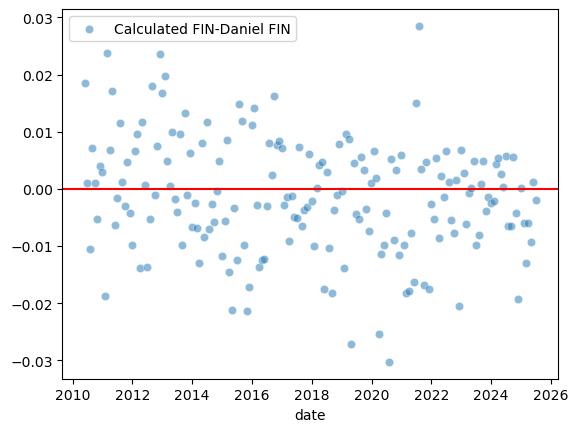

In [611]:
plt.figure()
sns.scatterplot(FIN-Daniel["R_fin"][Daniel["date"]>='2010-5-31'],alpha=0.5)

plt.legend(['Calculated FIN-Daniel FIN'])

plt.axhline(y=0, color='r')

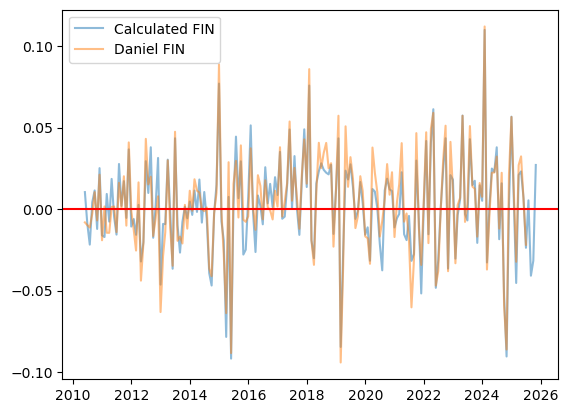

In [614]:
plt.plot(FIN[FIN.index>='2010-5-31'],alpha=0.5)
plt.plot(Daniel["R_fin"][Daniel["date"]>='2010-5-31'],alpha=0.5)
plt.legend(['Calculated FIN','Daniel FIN'])
plt.axhline(y=0, color='r')

动量因子计算如下

In [180]:
# 0. 读数据
mon_ret = mv_ret[["Stkcd",'date','ret']].copy()
mon_ret = mon_ret.rename(columns={'date':'Trdmnt', 'ret':'Mretwd'})
mon_ret = mon_ret.sort_values(['Stkcd', 'Trdmnt'])

In [ ]:
# 步骤1: 计算过去12个月（剔除最近1个月）的累计收益率
def calculate_momentum(df):
    df = df.sort_values(['Stkcd', 'Trdmnt'])
    
    # 计算每个月的累计收益率（过去11个月）
    df['cumret_11m'] = df.groupby('Stkcd')['Mretwd'].rolling(
        window=11, min_periods=11
    ).apply(lambda x: np.prod(1 + x) - 1).reset_index(level=0, drop=True)
    
    return df

# 应用动量计算
mon_ret = calculate_momentum(mon_ret)

In [237]:
mon_ret_copy=mon_ret.copy()

In [ ]:
mon_ret['cumret_11m']=mon_ret_copy.groupby('Stkcd')['cumret_11m'].shift(1)                  # 把整条序列挪 1 个月

In [251]:
mon_ret=pd.merge(mon_ret, mv_ret[['Stkcd','date','mv']], left_on=['Stkcd','Trdmnt'], right_on=['Stkcd','date'], how='left')

In [521]:
mon_ret=mon_ret.dropna(subset=['cumret_11m','mv']).copy()

In [522]:
# 步骤2: 在每个调仓日进行分组
def construct_momentum_portfolio(df):
    results = []
    
    # 获取所有调仓日期
    rebalance_dates = sorted(df['Trdmnt'].unique())
    
    for date in rebalance_dates:
        # 获取当前调仓日的数据
        current_data = df[df['Trdmnt'] == date].copy()
        current_data = current_data.dropna(subset=['cumret_11m'])
        
        if len(current_data) < 10:  # 确保有足够股票
            continue
            
        # 计算30%和70%分位数
        q30 = current_data['cumret_11m'].quantile(0.3)
        q70 = current_data['cumret_11m'].quantile(0.7)
        
        # 分组
        low_momentum = current_data[current_data['cumret_11m'] <= q30]  # 做空组
        high_momentum = current_data[current_data['cumret_11m'] >= q70]  # 做多组
        
        # 计算等权重收益率
        if len(low_momentum) > 0 and len(high_momentum) > 0:
            # 修改这两行代码：
            #low_ret = (low_momentum['Mretwd'] * low_momentum['mv']).sum() / low_momentum['mv'].sum()  # 做空组市值加权收益
            #high_ret = (high_momentum['Mretwd'] * high_momentum['mv']).sum() / high_momentum['mv'].sum()  # 做多组市值加权收益
            low_ret = low_momentum['Mretwd'].mean()
            high_ret = high_momentum['Mretwd'].mean()
            
            # 多空组合收益率 = 做多组 - 做空组
            long_short_ret = high_ret - low_ret
            
            results.append({
                'Trdmnt': date,
                'low_momentum_ret': low_ret,
                'high_momentum_ret': high_ret,
                'momentum_factor_ret': long_short_ret,
                'n_low': len(low_momentum),
                'n_high': len(high_momentum)
            })
    
    return pd.DataFrame(results)

# 构建动量因子组合
momentum_results = construct_momentum_portfolio(mon_ret)



In [523]:
# 显示结果
momentum_results

,Trdmnt,low_momentum_ret,high_momentum_ret,momentum_factor_ret,n_low,n_high
0,2001-11-30,0.072309,0.030425,-0.041885,338,338
1,2001-12-31,-0.076838,-0.038603,0.038235,348,348
2,2002-01-31,-0.141988,-0.127840,0.014148,353,353
3,2002-02-28,0.070471,0.023241,-0.047229,357,357
4,2002-03-31,0.101660,0.055521,-0.046139,360,360
...,...,...,...,...,...,...
283,2025-06-30,0.051551,0.066689,0.015138,1618,1618
284,2025-07-31,0.057618,0.041924,-0.015694,1619,1619
285,2025-08-31,0.061920,0.117977,0.056057,1619,1619
286,2025-09-30,0.005452,0.003976,-0.001476,1622,1622


In [524]:
# 计算累计收益率
momentum_results['cumulative_momentum'] = (1 + momentum_results['momentum_factor_ret']).cumprod() - 1
momentum_results['cumulative_high'] = (1 + momentum_results['high_momentum_ret']).cumprod() - 1
momentum_results['cumulative_low'] = (1 + momentum_results['low_momentum_ret']).cumprod() - 1

print("\n累计收益率:")
print(momentum_results[['Trdmnt', 'cumulative_momentum', 'cumulative_high', 'cumulative_low']].tail())


累计收益率:
        Trdmnt  cumulative_momentum  cumulative_high  cumulative_low
283 2025-06-30            -0.872162         4.379397       25.279607
284 2025-07-31            -0.874168         4.604920       26.793780
285 2025-08-31            -0.867115         5.266170       28.514757
286 2025-09-30            -0.867311         5.291083       28.675677
287 2025-10-31            -0.870456         5.282710       29.339603


In [525]:
UMD= momentum_results.set_index('Trdmnt')['momentum_factor_ret']

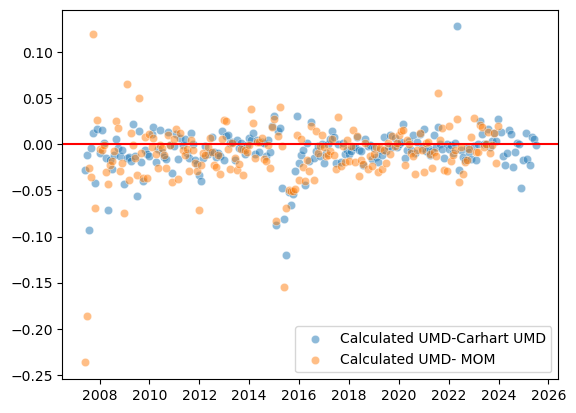

In [550]:
plt.figure()
sns.scatterplot(UMD-Carhart["UMD"][Carhart["date"]>='2007-5-31'],alpha=0.5)
sns.scatterplot(UMD-factors["mom"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated UMD-Carhart UMD','Calculated UMD- MOM'])
plt.axhline(y=0, color='r')


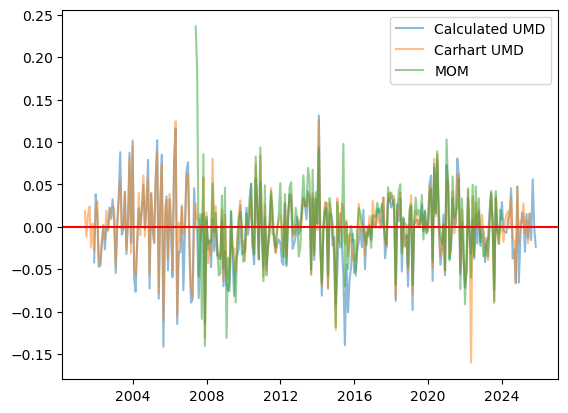

In [551]:
plt.plot(UMD,alpha=0.5)
plt.plot(Carhart["UMD"][Carhart["date"]>='2001-5-31'],alpha=0.5)
plt.plot(factors["mom"][factors["date"]>='2007-5-31'],alpha=0.5)
plt.legend(['Calculated UMD','Carhart UMD','MOM'])
plt.axhline(y=0, color='r')

In [604]:
total_factors = pd.DataFrame({
    'MKT': MKT,
    'SMB': SMB,
    'HML': HML,
    'FIN': FIN,
    'UMD': UMD
})

total_factors

,MKT,SMB,HML,FIN,UMD
2001-11-30,NaN,NaN,NaN,NaN,-0.041885
2001-12-31,NaN,NaN,NaN,NaN,0.038235
2002-01-31,NaN,NaN,NaN,NaN,0.014148
2002-02-28,NaN,NaN,NaN,NaN,-0.047229
2002-03-31,NaN,NaN,NaN,NaN,-0.046139
...,...,...,...,...,...
2025-06-30,0.042207,0.027911,-0.013249,-0.023706,0.015138
2025-07-31,0.045071,0.008336,0.002105,0.005401,-0.015694
2025-08-31,0.091553,-0.019036,-0.082672,-0.040811,0.056057
2025-09-30,0.012988,-0.011151,-0.023992,-0.031579,-0.001476


In [5]:
# 5. 一张汇总表（年化收益 + 年化波动 + 夏普）
def ann_rtn_sr(ts):
    ann_r = ts.mean() * 12
    ann_vol = ts.std() * np.sqrt(12)
    sr = ann_r / ann_vol
    return pd.Series({'ann_rtn': ann_r, 'ann_vol': ann_vol, 'sharpe': sr})

In [606]:
samp = total_factors.loc['2019-01-01':]

In [607]:
samp

,MKT,SMB,HML,FIN,UMD
2019-01-31,0.024547,-0.053611,0.030288,0.043426,0.023573
2019-02-28,0.174871,0.046266,-0.063670,-0.084505,-0.098364
2019-03-31,0.068174,0.044790,-0.037615,-0.025776,0.002020
2019-04-30,-0.015093,-0.023760,0.022724,0.023606,0.007556
2019-05-31,-0.059585,0.018447,-0.011504,0.018191,0.008267
...,...,...,...,...,...
2025-06-30,0.042207,0.027911,-0.013249,-0.023706,0.015138
2025-07-31,0.045071,0.008336,0.002105,0.005401,-0.015694
2025-08-31,0.091553,-0.019036,-0.082672,-0.040811,0.056057
2025-09-30,0.012988,-0.011151,-0.023992,-0.031579,-0.001476


In [608]:
# 4. 计算累计回报（复利）
cum_simple = (1 + samp[['MKT',"SMB","HML","FIN","UMD"]]).cumprod() - 1
cum_log = samp[['MKT',"SMB","HML","FIN","UMD"]].cumsum()   # 连续复利

In [609]:
summary = samp.pipe(lambda x: x[['MKT',"SMB","HML","FIN","UMD"]].apply(ann_rtn_sr))
print(summary.round(4))

            MKT     SMB     HML     FIN     UMD
ann_rtn  0.1182  0.0606 -0.0117  0.0150 -0.0083
ann_vol  0.1794  0.1435  0.1475  0.1108  0.1289
sharpe   0.6593  0.4220 -0.0792  0.1351 -0.0646


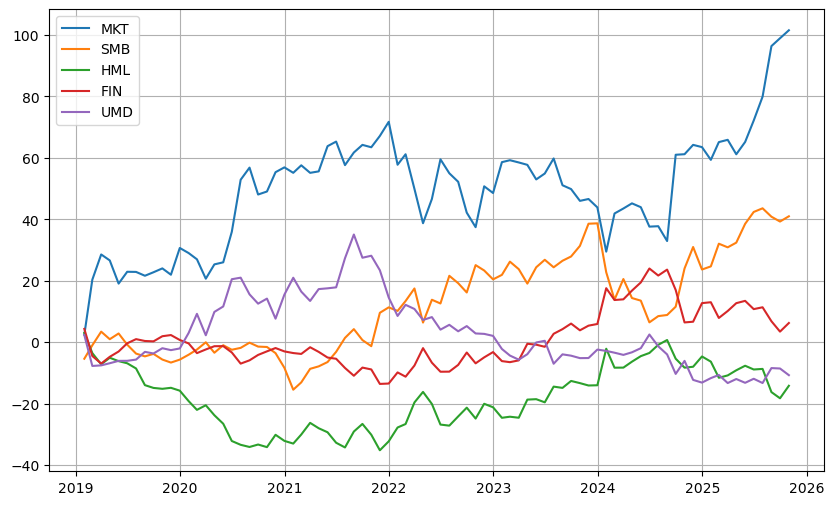

In [610]:
# 6. 画图（简单复利）
plt.figure(figsize=(10,6))
plt.plot(cum_simple.index, cum_simple*100)
plt.legend(cum_simple.columns)
plt.grid(True)
plt.show()

In [30]:
samp = factors.loc['2019-01-01':]

In [31]:
samp

,year,month,mkt,me,ia,roe,smbff5,hml,rmw,cma,mktch,smbch3,smbch4,vmg,pmo,smbff3,mom,monthlyrf,hmlff3,hmlff5
date,,,,,,,,,,,,,,,,,,,,
2019-01-31,2019,1,0.031315,-0.036874,-0.004204,0.053812,-0.044750,0.001480,0.030173,-0.023596,0.0288,-0.0460,-0.0511,0.0635,0.0326,-0.057379,0.026285,0.000917,-0.001923,0.001480
2019-02-28,2019,2,0.154238,0.067056,-0.017202,-0.069429,0.082054,-0.065197,-0.040880,-0.003279,0.1574,0.0504,0.0569,-0.0955,-0.0722,0.085426,-0.068458,0.000917,-0.070250,-0.065197
2019-03-31,2019,3,0.063906,0.048156,-0.010394,-0.015588,0.050142,-0.034118,0.000543,-0.020253,0.0644,0.0423,0.0466,-0.0281,0.0051,0.046590,0.005588,0.000917,-0.041467,-0.034118
2019-04-30,2019,4,-0.009435,-0.009177,-0.001868,0.018007,-0.018654,-0.004376,0.024185,-0.011658,-0.0133,-0.0229,-0.0245,0.0306,0.0260,-0.024223,0.034432,0.000917,-0.009075,-0.004376
2019-05-31,2019,5,-0.061198,0.020719,0.025205,-0.010172,0.020248,-0.015465,-0.019654,0.025852,-0.0636,0.0140,0.0169,0.0035,0.0371,0.025478,0.014106,0.000917,-0.013260,-0.015465
2019-06-30,2019,6,0.033186,-0.030915,0.007208,0.046360,-0.039346,-0.016620,0.032694,-0.008508,0.0315,-0.0322,-0.0380,0.0398,0.0086,-0.038621,0.019920,0.000917,-0.014921,-0.016620
2019-07-31,2019,7,-0.003268,-0.014316,-0.013279,0.006375,-0.014206,-0.007298,0.008436,-0.018908,-0.0017,-0.0311,-0.0308,0.0071,0.0118,-0.016434,0.002490,0.000917,-0.005652,-0.007298
2019-08-31,2019,8,-0.010779,-0.004592,-0.024245,-0.001893,-0.006443,-0.055852,0.009057,-0.037980,-0.0077,-0.0155,-0.0074,-0.0363,-0.0334,-0.005391,0.037516,0.000917,-0.051518,-0.055852
2019-09-30,2019,9,0.005678,0.015799,-0.012351,0.009539,0.014396,-0.001095,0.001476,-0.011352,0.0061,0.0069,0.0053,0.0113,0.0049,0.014436,-0.015035,0.000917,-0.001678,-0.001095


In [32]:
samp.drop(columns=['year'], inplace=True)

C:\Users\李想\AppData\Local\Temp\ipykernel_23664\1905550883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp.drop(columns=['year'], inplace=True)


In [33]:
samp.drop(columns=['month'], inplace=True)

C:\Users\李想\AppData\Local\Temp\ipykernel_23664\293088355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samp.drop(columns=['month'], inplace=True)


In [34]:
# 4. 计算累计回报（复利）
cum_simple = (1 + samp).cumprod() - 1
cum_log = samp.cumsum()

In [35]:
summary = samp.pipe(lambda x: x.apply(ann_rtn_sr))
print(summary.round(4))

            mkt      me      ia     roe  smbff5     hml     rmw     cma  \
ann_rtn  0.0722  0.0911  0.0528  0.0061  0.0902  0.0138 -0.0598  0.0347   
ann_vol  0.1648  0.1209  0.0657  0.0919  0.1373  0.1321  0.0966  0.0826   
sharpe   0.4380  0.7536  0.8036  0.0665  0.6573  0.1045 -0.6192  0.4202   

          mktch  smbch3  smbch4     vmg     pmo  smbff3     mom     monthlyrf  \
ann_rtn  0.1795  0.0125  0.0151  0.0507  0.0230  0.0690  0.0477  1.100000e-02   
ann_vol  0.1592  0.1435  0.1389  0.1369  0.1155  0.1442  0.1407  0.000000e+00   
sharpe   1.1272  0.0871  0.1087  0.3700  0.1991  0.4786  0.3388  3.227005e+15   

         hmlff3  hmlff5  
ann_rtn -0.0035  0.0138  
ann_vol  0.1198  0.1321  
sharpe  -0.0290  0.1045  


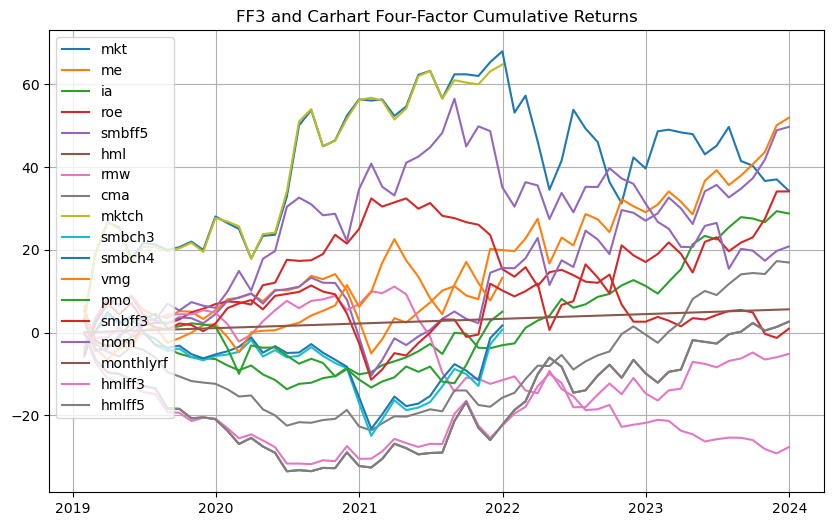

In [39]:
# 6. 画图（简单复利）
plt.figure(figsize=(10,6))
plt.plot(cum_simple.index, cum_simple*100)
plt.legend(cum_simple.columns,loc='upper left')
plt.title('FF3 and Carhart Four-Factor Cumulative Returns')
plt.grid(True)
plt.show()

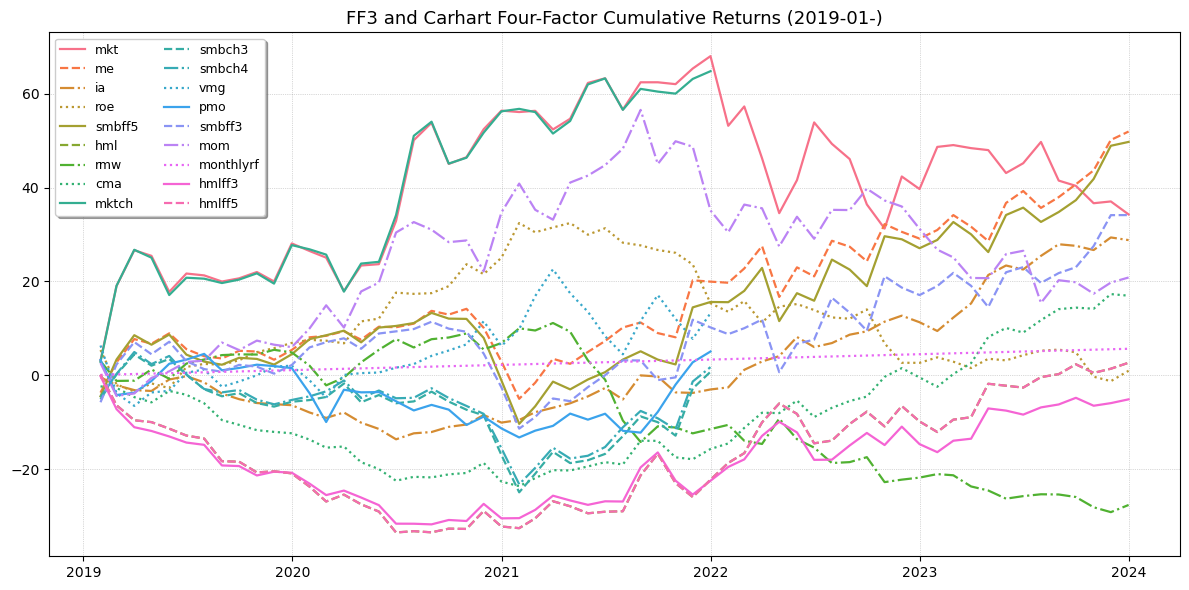

In [43]:
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette('husl', 18)
line_styles = ['-', '--', '-.', ':']

# 让线型循环到与颜色同长
line_cycle = cycle(line_styles)
style_long = [next(line_cycle) for _ in range(len(colors))]

# 一次性生成 (color, linestyle) 对
for i, (col, sty) in enumerate(zip(colors, style_long)):
    ax.plot(cum_simple.index, cum_simple.iloc[:, i] * 100,
            color=col, linestyle=sty, linewidth=1.6, label=cum_simple.columns[i])

ax.legend(loc='upper left', ncol=2, frameon=True, shadow=True, fontsize=9)
ax.set_title('FF3 and Carhart Four-Factor Cumulative Returns (2019-01-)', fontsize=13)
ax.grid(True, ls=':', lw=0.5, color='grey', alpha=0.6)
fig.tight_layout()
plt.show()